In [28]:
] activate .

  Activating project at `~/devansh/HJB.jl/examples`


In [29]:
] st

Status `~/devansh/HJB.jl/examples/Project.toml`
  [0c46a032] DifferentialEquations v7.12.0
  [a3cb4e6c] HJB v1.0.0-DEV `..`
  [91a5bcdd] Plots v1.40.1
  [49802e3a] ProgressBars v1.5.1
  [295af30f] Revise v3.5.13
  [90137ffa] StaticArrays v1.9.2
  [5d786b92] TerminalLoggers v0.1.7


In [30]:
] precompile 

## Import Dependencies

In [31]:
# the first thing to do is to set up the loggers
# for the differential equation solver
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger() )

# now import all the libraries
using Plots, DifferentialEquations, LinearAlgebra, StaticArrays

using HJB

using BenchmarkTools

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [32]:
Threads.nthreads()

16

## Problem 1: Double Integrator with Walls

### Define the Dynamics, and the Hamiltonian

In [34]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

# define the Hamiltonian
function H(t, x, V, DxV)
    u1 = @SVector [1.0]
    u2 = @SVector [-1.0]
    H1 = DxV' * f(t, x, u1)
    H2 = DxV' * f(t, x, u2)
    γ = 1.0

    # CBF Hamiltonian!
    return min(0, max(H1, H2) + γ*V)
    # return max(H1, H2) + γ*V
end

# define the constraint function
function l(x)
    xcon = 0.5 - x[1]^2
    return xcon
end


HJB.LocalLaxFriedrichsNHM{HJB.LeftWenoGradient{Float64}, HJB.RightWenoGradient{Float64}, typeof(dissipation_coefficients)}(HJB.LeftWenoGradient{Float64}(1.0e-6), HJB.RightWenoGradient{Float64}(1.0e-6), dissipation_coefficients)

### Define the Numerical Hamiltonian

In [ ]:

# you need to define some dissipation coefficients
# this is a vector of maximum absolute derivatives of H along each spatial dimension
# function dissipation_coefficients(t, x)
#     return @SVector [1.0, 1.0]
# end

function dissipation_coefficients(t, x)
    return @SVector [abs(x[2]), 1.0]
end

numericalHamiltonianMethod = HJB.LocalLaxFriedrichsNHM(
    HJB.LeftWenoGradient(),
    HJB.RightWenoGradient(), 
    dissipation_coefficients
    )

### Create a Grid

In [35]:
x1s = -1:0.025:1
x2s = -2:0.025:2
grid = HJB.Grid((x1s, x2s))

HJB.Grid{2, Float64}((-1.0, -2.0), (0.025, 0.025), (81, 161), 3)

### Construct the ODE Problem

In [36]:
prob = HJB.get_ODEProblem(H, l, grid, (0.0, -2.0), numericalHamiltonianMethod)

ODEProblem with uType OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (0.0, -2.0)
u0: 87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0   0.0        0.0       …   0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0  -0.5       -0.5          -0.5       -0.5       0.0  0.0  0.0
 0.0  0.0  0.0  -0.450625  -0.450625     -0.450625  -0.450625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.4025    -0.4025    …  -0.4025    -0.4025    0.0  0.0  0.0
 0.0  0.0  0.0  -0.355625  -0.355625     -0.355625  -0.355625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.31      -0.31         -0.31      -0.31      0.0  0.0  0.0
 0.0  0.0  0.0  -0.265625  -0.265625     -0.265625  -0.265625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.2225    -0.2225       -0.2225    -0.2225    0.0  0.0  

### Plot the Value function at the terminal time
This is just a sanity check

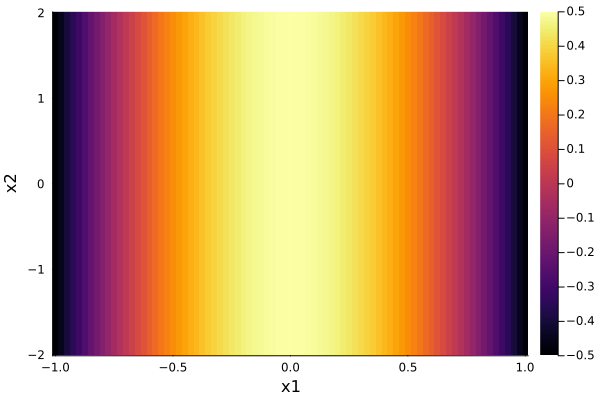

In [55]:
hjb_plot(grid, prob.u0)

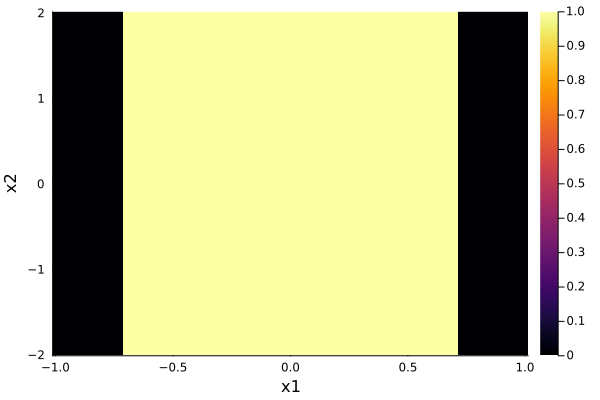

In [56]:
hjb_plot(grid, prob.u0 .>= 0.0)

### Solve the ODE Problem

In [57]:
# Choose any solver from `DifferentialEquations.jl`. Here are some choices:
#   SSPRK54() # good
#   SSPRK53() # good
#   SSPRK22() # good
#   SSPRK43() # very slow
#   Tsit5() # good
#   unspecified # good

@time sol = solve(prob; reltol=1e-6, abstol=1e-6, progress=true, dt=1e-3, alg=SSPRK53())

  4.483749 seconds (4.06 M allocations: 935.276 MiB, 5.48% gc time)


ODE   0%|                                               |  ETA: N/A
ODE  50%|███████████████████████▌                       |  ETA: 0:00:02
ODE 100%|███████████████████████████████████████████████|  ETA: N/A
ODE 100%|███████████████████████████████████████████████| Time: 0:00:04


retcode: Success
Interpolation: 3rd order Hermite
t: 2002-element Vector{Float64}:
  0.0
 -0.001
 -0.002
 -0.003
 -0.004
 -0.005
 -0.006
 -0.007
 -0.008
 -0.009000000000000001
 -0.010000000000000002
 -0.011000000000000003
 -0.012000000000000004
  ⋮
 -1.9899999999998916
 -1.9909999999998915
 -1.9919999999998914
 -1.9929999999998913
 -1.9939999999998912
 -1.994999999999891
 -1.995999999999891
 -1.9969999999998909
 -1.9979999999998908
 -1.9989999999998906
 -1.9999999999998905
 -2.0
u: 2002-element Vector{OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 

### Plot the Solutions

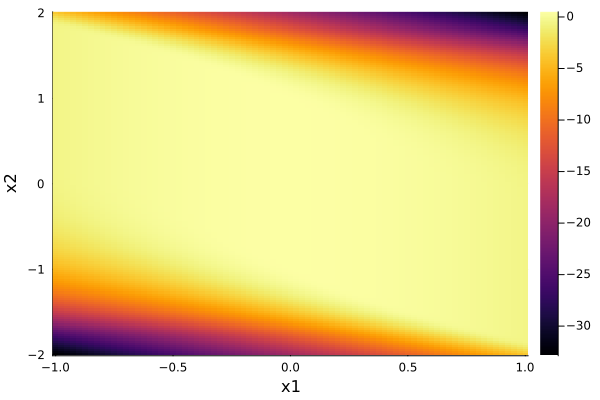

In [59]:
hjb_plot(grid, sol.u[end])

Draw a Level Set, along with the theory bound

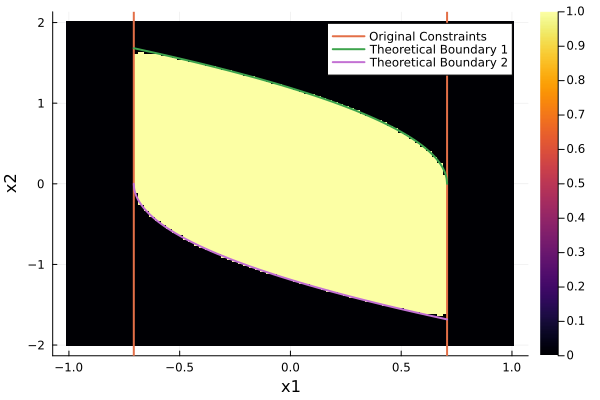

In [64]:
plot()
hjb_plot!(grid, sol.u[end] .>= 0.0)
vline!([-sqrt(2)/2, sqrt(2)/2], linewidth=2, label="Original Constraints")
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2, linewidth=2, label="Theoretical Boundary 1")
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2, linewidth=2, label="Theoretical Boundary 2")

## Problem 2: Double Integrator with constraints in both position and velocity

### Define a new constraint

In [68]:
function l2(x)
    xcon = sqrt(2)/2 - sqrt(x[1]^2 + x[2]^2/4)
    return xcon
end

l2 (generic function with 1 method)

### Create the new ODE problem

In [69]:
prob2 = HJB.get_ODEProblem(H, l2, grid, (2.0, 0.0), numericalHamiltonianMethod)

ODEProblem with uType OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (2.0, 0.0)
u0: 87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0   0.0        0.0       …   0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0  -0.707107  -0.698296     -0.698296  -0.707107  0.0  0.0  0.0
 0.0  0.0  0.0  -0.689541  -0.680618     -0.680618  -0.689541  0.0  0.0  0.0
 0.0  0.0  0.0  -0.672205  -0.663169  …  -0.663169  -0.672205  0.0  0.0  0.0
 0.0  0.0  0.0  -0.655106  -0.645957     -0.645957  -0.655106  0.0  0.0  0.0
 0.0  0.0  0.0  -0.638256  -0.628991     -0.628991  -0.638256  0.0  0.0  0.0
 0.0  0.0  0.0  -0.621661  -0.61228      -0.61228   -0.621661  0.0  0.0  0.0
 0.0  0.0  0.0  -0.605334  -0.595835     -0.595835  -0.605334  0.0  0.0  0

### Plot the target level set
again, just a sanity check

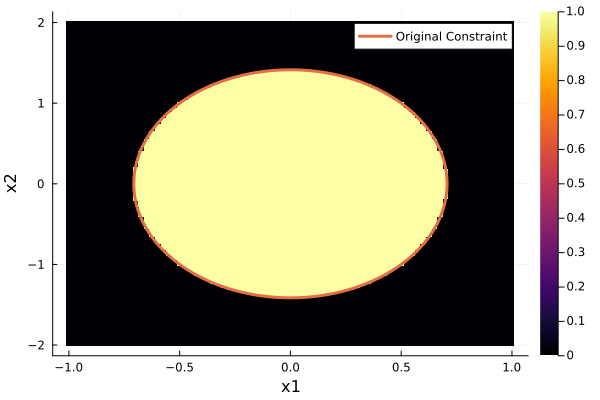

In [72]:
hjb_plot(grid, prob2.u0 .>= 0.0)
plot!(θ-> sqrt(2)/2 * cos(θ), θ-> sqrt(2) * sin(θ), 0, 2π, linewidth = 3, label="Original Constraint")

### Solve the problem

In [73]:
@time sol2 = solve(prob2; reltol=1e-6, abstol=1e-6, progress=true, dt=1e-3, alg=SSPRK53())

  4.758278 seconds (4.06 M allocations: 935.276 MiB, 4.09% gc time)


ODE   0%|                                               |  ETA: N/A
ODE  50%|███████████████████████▌                       |  ETA: 0:00:02
ODE 100%|███████████████████████████████████████████████|  ETA: N/A
ODE 100%|███████████████████████████████████████████████| Time: 0:00:04


retcode: Success
Interpolation: 3rd order Hermite
t: 2002-element Vector{Float64}:
 2.0
 1.999
 1.9980000000000002
 1.9970000000000003
 1.9960000000000004
 1.9950000000000006
 1.9940000000000007
 1.9930000000000008
 1.9920000000000009
 1.991000000000001
 1.990000000000001
 1.9890000000000012
 1.9880000000000013
 ⋮
 0.010000000000109255
 0.009000000000109254
 0.008000000000109253
 0.007000000000109253
 0.006000000000109253
 0.005000000000109253
 0.004000000000109253
 0.003000000000109253
 0.002000000000109253
 0.001000000000109253
 1.0925288451701931e-13
 0.0
u: 2002-element Vector{OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 …

### Plot the solutions

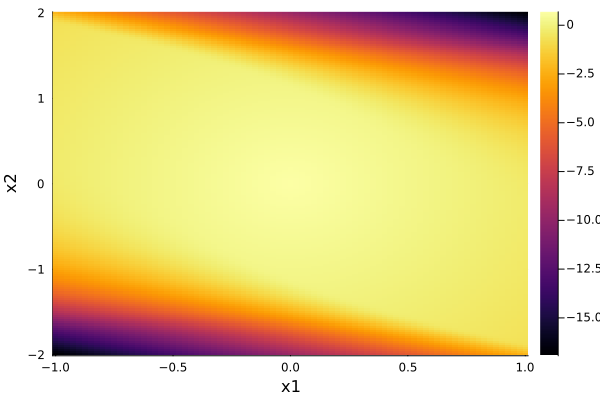

In [74]:
plot()
hjb_plot!(grid, sol2.u[end])

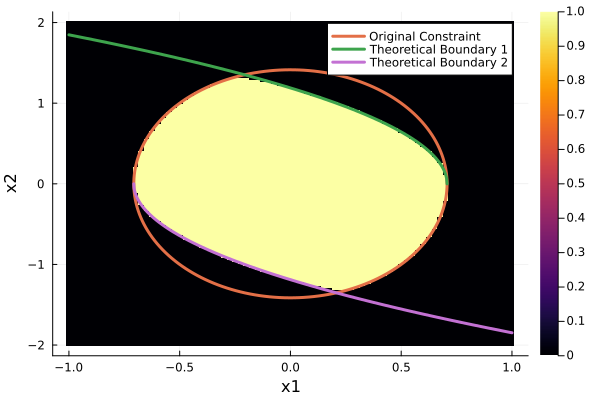

In [76]:
plot()
hjb_plot!(grid, sol2.u[end] .>= 0.0)
plot!(θ-> sqrt(2)/2 * cos(θ), θ-> sqrt(2) * sin(θ), 0, 2π, linewidth = 3, label="Original Constraint")
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -1, sqrt(2)/2, linewidth=3, label="Theoretical Boundary 1")
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, 1, linewidth=3, label="Theoretical Boundary 2")

### You can also plot the data in other formats

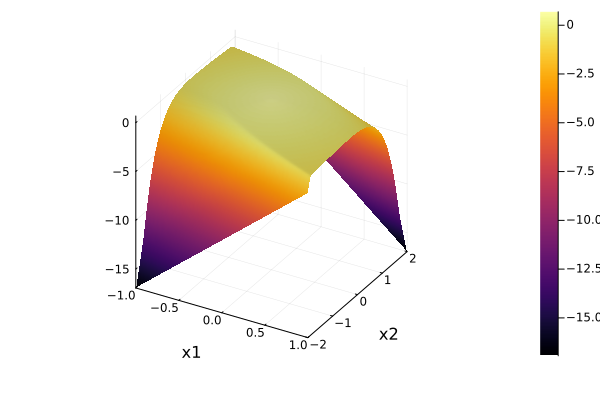

In [77]:
plot()
hjb_plot!(grid, sol2.u[end]; seriestype=:surface)

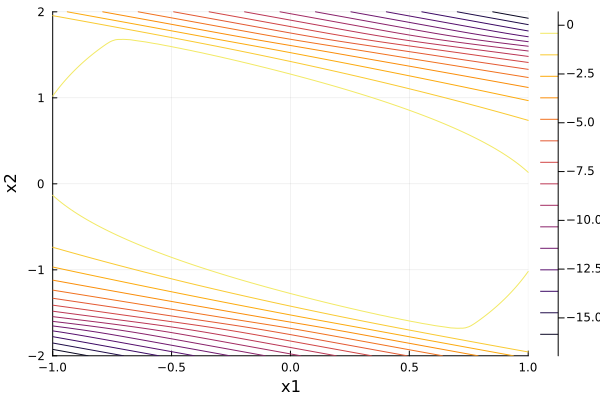

In [78]:
plot()
hjb_plot!(grid, sol2.u[end]; seriestype=:contour)

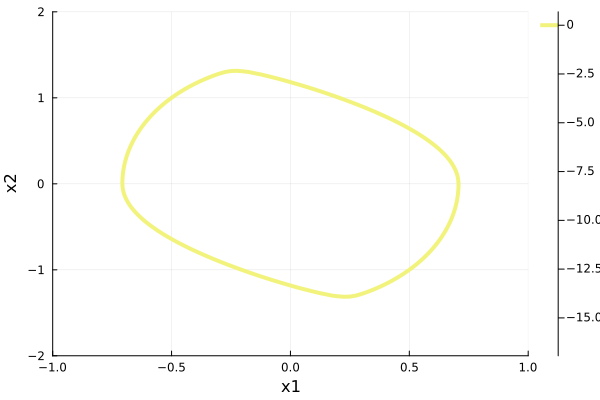

In [82]:
plot()
hjb_plot!(grid, sol2.u[end]; seriestype=:contour, levels=[0.0], linewidth=4)

The default is a heatmap

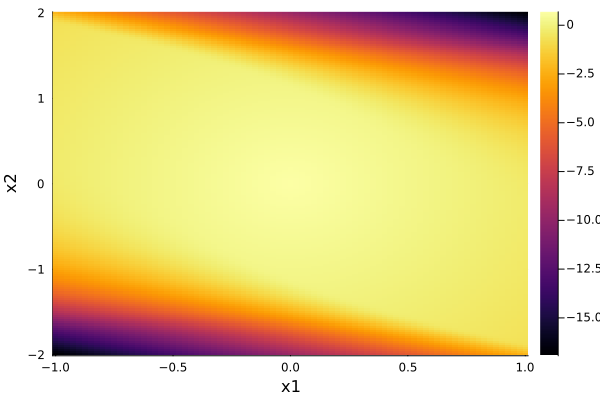

In [83]:
hjb_plot(grid, sol2.u[end]; seriestype=:heatmap)